# Solving 2D Poisson Equation using Physics-Informed Neural Networks (PINNs)

## Introduction

In this tutorial, we will solve the poisson equation on a square domain $[0,1]^2$ with homogeneous Dirichlet boundary conditions $(u = 0$ on the boundary).
In two dimensions, it takes the form:

$-\Delta u = f(x,y)$

where:
* $\Delta = \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}$ is the Laplacian operator.
* $u(x,y)$ is the unknown function we want to solve for.
* $f(x,y)$ is a known source function.



## 1. Importing the required libraries

In [98]:
import tensorflow as tf
import pyDOE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seeds for reproducibility

tf.random.set_seed(42)


### Latin Hypercube Sampling with pyDOE

Latin hypercube sampling (LHS) is a statistical method for generating a near random samples with equal intervals.


why lhs?


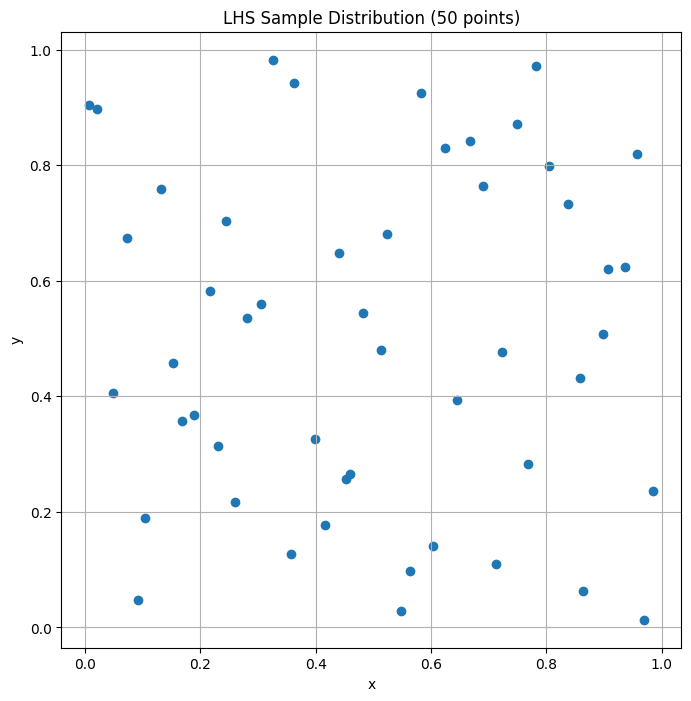

In [99]:
# Generate and visualize samples
samples = pyDOE.lhs(2, samples=50)
plt.figure(figsize=(8, 8))
plt.scatter(samples[:,0], samples[:,1])
plt.grid(True)
plt.title('LHS Sample Distribution (50 points)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## 2. Generate Training Points

We'll generate two sets of points to train our Physics-Informed Neural Network:

1. **Boundary Points**: These points lie on the edges of our domain $[0,1]^2$
   * Generated using Latin Hypercube Sampling (LHS)
   * Used to enforce Dirichlet boundary conditions $(u = 0)$
2. **Interior Points**: These points fill the inside of our domain
   * Also generated using Latin Hypercube Sampling
   * Used to enforce the PDE $(\nabla^2u = f(x,y))$



In [100]:
# Define domain boundaries and number of points
total_points = 10000
bound_points = 50
lower_bounds = np.array([0.0, 0.0])
upper_bounds = np.array([1.0, 1.0])

# Generate boundary points using LHS
bound_lhs = pyDOE.lhs(2, samples=bound_points)
boundary_points = bound_lhs * (upper_bounds - lower_bounds) + lower_bounds

# Generate interior points using LHS
int_lhs = pyDOE.lhs(2, samples=total_points-bound_points)
int_points = int_lhs * (upper_bounds - lower_bounds) + lower_bounds

# Combine all points
points = np.vstack((boundary_points, int_points))
x_points = points[:, 0]
y_points = points[:, 1]

# Convert to TensorFlow tensors
x_points_tf = tf.convert_to_tensor(x_points, dtype=tf.float32)
y_points_tf = tf.convert_to_tensor(y_points, dtype=tf.float32)
boundary_points_tf = tf.convert_to_tensor(boundary_points, dtype=tf.float32)

## 3. Define Neural Network Architecture

We'll use a feedforward neural network with the following structure:

* Input Layer: 2 neurons (x, y coordinates)
* Hidden Layers: 3 layers × 50 neurons with tanh activation
* Output Layer: 1 neuron (predicted u value)

In [101]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(2,)),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(1)
])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 50)                150       
                                                                 
 dense_29 (Dense)            (None, 50)                2550      
                                                                 
 dense_30 (Dense)            (None, 50)                2550      
                                                                 
 dense_31 (Dense)            (None, 1)                 51        
                                                                 
Total params: 5301 (20.71 KB)
Trainable params: 5301 (20.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## 4. Define the Source Function and PDE Residual

Here we define two key components with ω (omega) as a parameter to control the frequency of oscillations:

1. **Source Function f(x,y,ω)**:
  * Right-hand side of the Poisson equation ∇²u = f(x,y)
  * Defined as: f(x,y) = -2ω²sin(ωx)sin(ωy)
  * ω controls the frequency of the solution

2. **PDE Residual**:
  * Computes ∇²u = ∂²u/∂x² + ∂²u/∂y²
  * Measures how well our solution satisfies the PDE

In [102]:
def analytical_solution(x, y, omega=2.0*np.pi):
    """
    Compute analytical solution for the 2D Poisson equation
    Args:
        x: x coordinates (meshgrid)
        y: y coordinates (meshgrid)
        omega: frequency parameter (default: 2π)
    Returns:
        U: analytical solution on the given grid
    """
    return np.sin(omega * x) * np.sin(omega * y)

In [103]:
@tf.function
def f(x, y, omega=2.0*np.pi):
    """
    Source function with controllable frequency
    Args:
        x, y: spatial coordinates
        omega: frequency parameter (default: 2π)
    """
    # u = analytical_solution(x, y,omega=2.0*np.pi)
    # u_x = tf.gradients(u, x)[0]
    # u_y = tf.gradients(u, y)[0]
    # u_xx = tf.gradients(u_x, x)[0]
    # u_yy = tf.gradients(u_y, y)[0]
    # return -(u_xx + u_yy)
    
    return -2.0 * omega**2 * tf.math.sin(omega * x) * tf.math.sin(omega * y)


@tf.function
def pde(x, y, u, omega=2.0*np.pi):
    """
    PDE residual computation
    Args:
        x, y: spatial coordinates
        u: predicted solution
        omega: frequency parameter (default: 2π)
    """
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(y)
        u = model(tf.stack([x, y], axis=1))
        u_x = tape.gradient(u, x)
        u_y = tape.gradient(u, y)
    u_xx = tape.gradient(u_x, x)
    u_yy = tape.gradient(u_y, y)
    
    return u_xx + u_yy + f(x, y, omega)

## 5. Loss Function Definition with Boundary Weight

The total loss combines:
1. **PDE Loss**: Measures Poisson equation satisfaction
2. **Boundary Loss**: Weighted term (β) for boundary conditions

In [104]:
@tf.function
def compute_loss(x, y, x_boundary, y_boundary, beta=10.0, omega=2.0*np.pi):
    """
    Compute total loss with weighted boundary conditions
    Args:
        x, y: coordinates for PDE loss
        x_boundary, y_boundary: coordinates for boundary conditions
        beta: weight for boundary loss (default: 10.0)
        omega: frequency parameter (default: 2π)
    Returns:
        total_loss, pde_loss, boundary_loss
    """
    # Compute PDE residual
    u = model(tf.stack([x, y], axis=1))
    residual_pde = pde(x, y, u, omega)
    pde_loss = tf.reduce_mean(tf.square(residual_pde))
    
    # Compute weighted boundary loss
    u_boundary = model(tf.stack([x_boundary, y_boundary], axis=1))
    boundary_loss = beta* tf.reduce_mean(tf.square(u_boundary))
    
    # Total loss
    total_loss = pde_loss + boundary_loss
    
    return total_loss, pde_loss, boundary_loss

## Training loop


In [105]:
n_epochs = 50000
omega=2.0*np.pi
beta = 10.0
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
history = {
    'total_loss': [],
    'pde_loss': [],
    'boundary_loss': []
}

# Training loop
for epoch in range(n_epochs):

    with tf.GradientTape() as tape:
        loss, pde_loss, bc_loss = compute_loss(
            x_points_tf, 
            y_points_tf,
            boundary_points_tf[:, 0],
            boundary_points_tf[:, 1],
            beta, omega)
    
    # Get gradients and update weights
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Store losses
    history['total_loss'].append(loss.numpy())
    history['pde_loss'].append(pde_loss.numpy())
    history['boundary_loss'].append(bc_loss.numpy())
    
    # Print progress every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}:')
        print(f'  Total Loss: {loss.numpy():.6f}')
        print(f'  PDE Loss: {pde_loss.numpy():.6f}')
        print(f'  Boundary Loss: {bc_loss.numpy():.6f}\n')

Epoch 0:
  Total Loss: 1562.410156
  PDE Loss: 1555.054810
  Boundary Loss: 7.355360

Epoch 1000:
  Total Loss: 105.548904
  PDE Loss: 14.395741
  Boundary Loss: 91.153168

Epoch 2000:
  Total Loss: 72.232605
  PDE Loss: 8.521145
  Boundary Loss: 63.711464

Epoch 3000:
  Total Loss: 61.583305
  PDE Loss: 6.913752
  Boundary Loss: 54.669552

Epoch 4000:
  Total Loss: 57.483177
  PDE Loss: 7.335786
  Boundary Loss: 50.147392

Epoch 5000:
  Total Loss: 53.824112
  PDE Loss: 6.811411
  Boundary Loss: 47.012703

Epoch 6000:
  Total Loss: 50.516842
  PDE Loss: 5.608168
  Boundary Loss: 44.908672

Epoch 7000:
  Total Loss: 48.495647
  PDE Loss: 5.052885
  Boundary Loss: 43.442764

Epoch 8000:
  Total Loss: 46.673969
  PDE Loss: 4.697726
  Boundary Loss: 41.976242

Epoch 9000:
  Total Loss: 46.116985
  PDE Loss: 4.923387
  Boundary Loss: 41.193600

Epoch 10000:
  Total Loss: 43.957764
  PDE Loss: 4.155981
  Boundary Loss: 39.801785

Epoch 11000:
  Total Loss: 42.546230
  PDE Loss: 3.881851
  B


## Analytical Solution Function

Function to compute the analytical solution of the 2D Poisson equation:   

In [106]:
def analytical_solution(x, y, omega=2.0*np.pi):
    """
    Compute analytical solution for the 2D Poisson equation
    Args:
        x: x coordinates (meshgrid)
        y: y coordinates (meshgrid)
        omega: frequency parameter (default: 2π)
    Returns:
        U: analytical solution on the given grid
    """
    return np.sin(omega * x) * np.sin(omega * y)

## 7. Testing and Visualization

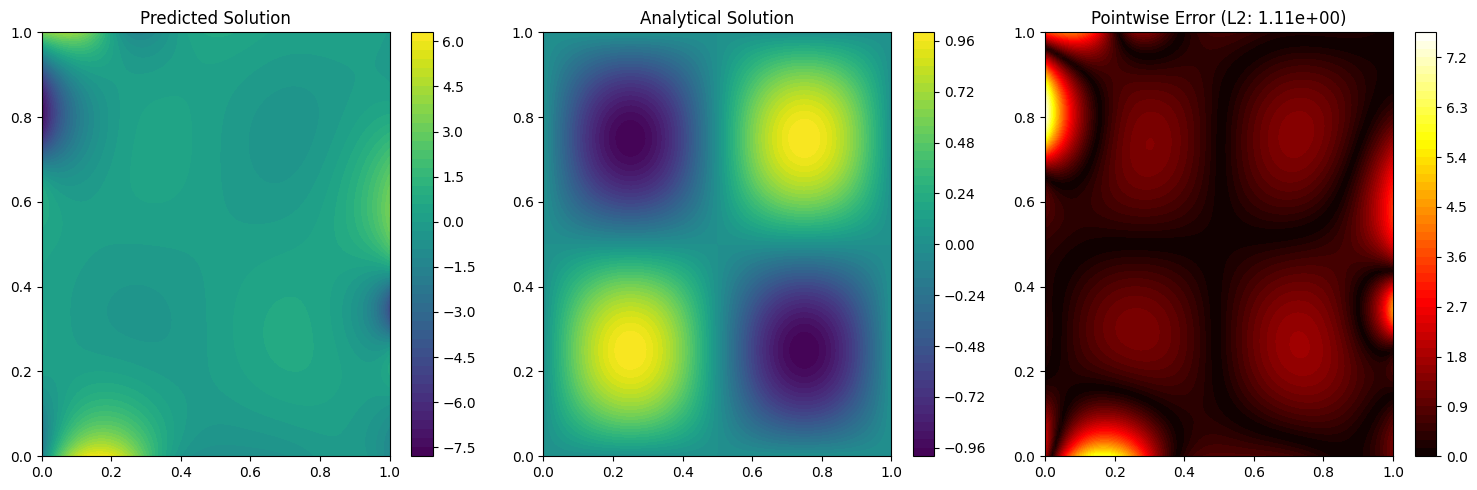


L2 Error: 1.11e+00


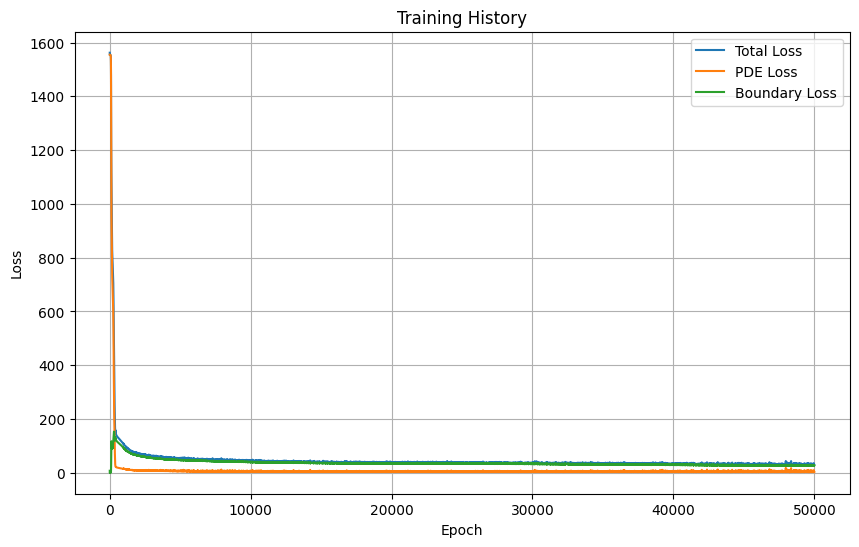

In [107]:
def plot_training_history(history):
    """Plot training history with regular scale"""
    plt.figure(figsize=(10, 6))
    plt.plot(history['total_loss'], label='Total Loss')
    plt.plot(history['pde_loss'], label='PDE Loss')
    plt.plot(history['boundary_loss'], label='Boundary Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.title('Training History')
    plt.show()

 

def test_and_visualize(model, nx=100, ny=100):
    """
    Test PINN on a uniform grid and visualize results
    Args:
        model: trained PINN model
        nx, ny: number of points in x and y directions
    """
    # Generate uniform grid for testing
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    X, Y = np.meshgrid(x, y)
    
    # Prepare input points
    X_flat = X.flatten()
    Y_flat = Y.flatten()
    xy_test = np.stack([X_flat, Y_flat], axis=-1)
    
    # Get predictions
    u_pred = model(xy_test).numpy()
    U_pred = u_pred.reshape(nx, ny)

    U_analytical=analytical_solution(X, Y, omega=2.0*np.pi)

    # Compute error
    error = np.abs(U_pred - U_analytical)
    l2_error = np.sqrt(np.mean((U_pred - U_analytical)**2))
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot predicted solution
    im1 = axes[0].contourf(X, Y, U_pred, levels=50, cmap='viridis')
    axes[0].set_title('Predicted Solution')
    fig.colorbar(im1, ax=axes[0])

    
    # Plot analytical solution
    im2 = axes[1].contourf(X, Y, U_analytical, levels=50, cmap='viridis')
    axes[1].set_title('Analytical Solution')
    fig.colorbar(im2, ax=axes[1])
    
    # Plot pointwise error
    im3 = axes[2].contourf(X, Y, error, levels=50, cmap='hot')
    axes[2].set_title(f'Pointwise Error (L2: {l2_error:.2e})')
    fig.colorbar(im3, ax=axes[2])
    
    plt.tight_layout()
    plt.show()
    
    return l2_error

# Test and visualize results
l2_error = test_and_visualize(model)
print(f'\nL2 Error: {l2_error:.2e}')

# Plot training history
plot_training_history(history)

### Inverse Problem 

Modifying PINN for the inverse problem:
* Domain: Ω = (0,1)²
* Equation: -ϵ∆u(x) = f(x)
* Unknown parameter: ϵ (diffusion coefficient)
* Initial guess: ϵ₀ = 2.0
* True value: ϵ = 0.3

In [108]:
def analytical_solution_inverse(x, y, epsilon):
    """
    Analytical solution for the inverse problem
    Args:
        x, y: spatial coordinates in [0,1]²
        epsilon: diffusion coefficient
    Returns:
        u: exact solution
    """
    return 10 * np.sin(np.pi*x) * np.tanh(x) * np.exp(-epsilon * x**2)



In [109]:
def generate_sensor_data(n_sensors=50):
    """Generate random sensor locations and measurements"""
    # Random points in [0,1]²
    sensor_x = tf.random.uniform((n_sensors,), 0.0, 1.0)
    sensor_y = tf.random.uniform((n_sensors,), 0.0, 1.0)
    locations = tf.stack([sensor_x, sensor_y], axis=1)
    
    # True measurements
    epsilon_true = 0.3
    measurements = analytical_solution_inverse(sensor_x, sensor_y, epsilon_true)
    
    return locations, measurements

### 1. Source Term Function
The source term f(x,y) is calculated by applying the PDE operator to the known analytical solution:

In [110]:
def f(x, y, epsilon=0.3):
    #find diff square of u
    u = analytical_solution_inverse(x, y, epsilon)
    u_x = tf.gradients(u, x)[0]
    u_y = tf.gradients(u, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    return -epsilon*(u_xx + u_yy)


### 2. PDE Residual for Inverse Problem

In [111]:
@tf.function
def inverse_pde_residual(model, x, y):
    """
    Compute PDE residual for the inverse Poisson problem: -ϵ∆u = f
    Args:
        model: PINN model with trainable epsilon
        x, y: spatial coordinates
    Returns:
        residual: PDE residual at given points
    """
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, y])
        u = model(tf.stack([x, y], axis=1))
        u_x = tape.gradient(u, x)
        u_y = tape.gradient(u, y)
    u_xx = tape.gradient(u_x, x)
    u_yy = tape.gradient(u_y, y)
    del tape

    # PDE residual: -ϵ∆u = f
    residual = -model.epsilon *(u_xx + u_yy)- f(x, y, epsilon = 0.3)
    
    return residual

### 3. Inverse Problem with Multiple Loss Components

Loss function components:
1. **PDE Loss**: Measures equation satisfaction
2. **Sensor Loss**: Weighted term (α) for sensor measurements
3. **Boundary Loss**: Weighted term (β) for boundary conditions

In [112]:
@tf.function
def compute_losses(model, x, y, u_sensors, sensor_locations, x_boundary, y_boundary, alpha=1.0, beta=1.0):
    """
    Compute all loss components
    Args:
        model: PINN model
        x, y: domain points
        u_sensors: sensor measurements
        sensor_locations: sensor coordinates
        x_boundary, y_boundary: boundary points
        alpha: weight for sensor loss
        beta: weight for boundary loss
    Returns:
        pde_loss, sensor_loss, boundary_loss
    """
    # PDE loss
    residual = inverse_pde_residual(model, x, y)
    pde_loss = tf.reduce_mean(tf.square(residual))
    
    # Sensor loss
    u_pred = model(sensor_locations)
    sensor_loss = alpha * tf.reduce_mean(tf.square(u_pred - u_sensors))
    
    # Boundary loss
    u_boundary = model(tf.stack([x_boundary, y_boundary], axis=1))
    boundary_loss = beta * tf.reduce_mean(tf.square(u_boundary))
    
    return pde_loss, sensor_loss, boundary_loss

In [71]:
#training loop
n_sensors = 50
n_epochs = 50000
alpha = 1.0
beta = 10.0
epsilon = 0.3
epsilon_init = 2.0
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
history = {
    'pde_loss': [],
    'sensor_loss': [],
    'boundary_loss': []
}
locations, measurements = generate_sensor_data(n_sensors)
for epoch in range(n_epochs):
    with tf.GradientTape() as tape:
        # Compute losses
        pde_loss, sensor_loss, boundary_loss = compute_losses(
            model, x_points_tf, y_points_tf, measurements,locations,
            boundary_points_tf[:, 0], boundary_points_tf[:, 1],
            alpha, beta)
        
        # Total loss
        total_loss = pde_loss + sensor_loss + boundary_loss
    
    # Get gradients and update weights
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # Store losses
    history['pde_loss'].append(pde_loss.numpy())
    history['sensor_loss'].append(sensor_loss.numpy())
    history['boundary_loss'].append(boundary_loss.numpy())
    
    # Print progress every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}:')
        print(f'  PDE Loss: {pde_loss.numpy():.6f}')
        print(f'  Sensor Loss: {sensor_loss.numpy():.6f}')
        print(f'  Boundary Loss: {boundary_loss.numpy():.6f}\n')

In [113]:
def test_inverse_problem(model, nx=40, ny=40):
    """Test the inverse problem solution"""
    # Generate uniform grid
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    X, Y = np.meshgrid(x, y)
    
    # Prepare input points
    xy_test = np.stack([X.flatten(), Y.flatten()], axis=-1)
    
    # Get predictions
    u_pred = model(xy_test).numpy().reshape(nx, ny)
    
    # Compute analytical solution
    U_analytical = analytical_solution_inverse(X, Y, 0.3)  # true epsilon
    
    # Compute error
    error = np.abs(u_pred - U_analytical)
    l2_error = np.sqrt(np.mean((u_pred - U_analytical)**2))
    
    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    im1 = axes[0].contourf(X, Y, u_pred, levels=50, cmap='viridis')
    axes[0].set_title('Predicted Solution')
    fig.colorbar(im1, ax=axes[0])
    
    im2 = axes[1].contourf(X, Y, U_analytical, levels=50, cmap='viridis')
    axes[1].set_title('Analytical Solution')
    fig.colorbar(im2, ax=axes[1])
    
    im3 = axes[2].contourf(X, Y, error, levels=50, cmap='hot')
    axes[2].set_title(f'Error (L2: {l2_error:.2e})')
    fig.colorbar(im3, ax=axes[2])
    
    plt.tight_layout()
    plt.show()
    
    print(f'Predicted ϵ: {float(model.epsilon):.6f}')
    print(f'L2 Error: {l2_error:.2e}')

In [114]:
@tf.function
def train_step(x, y, x_boundary, y_boundary, optimizer, beta=10.0, omega=2.0*np.pi):
    """
    Single training step with gradient descent
    """
    with tf.GradientTape() as tape:
        loss, pde_loss, boundary_loss = compute_loss(x, y, x_boundary, y_boundary, beta, omega)
        
    # Get gradients and update weights
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, pde_loss, boundary_loss

# Training parameters
n_epochs = 50000
omega=2.0*np.pi
beta = 10.0
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
history = {
    'total_loss': [],
    'pde_loss': [],
    'boundary_loss': []
}

# Training loop
for epoch in range(n_epochs):
    loss, pde_loss, bc_loss = train_step(
        x_points_tf, 
        y_points_tf,
        boundary_points_tf[:, 0],
        boundary_points_tf[:, 1],
        optimizer, beta, omega)
    
    
    # Store losses
    history['total_loss'].append(loss.numpy())
    history['pde_loss'].append(pde_loss.numpy())
    history['boundary_loss'].append(bc_loss.numpy())
    
    # Print progress every 1000 epochs
    if epoch % 1000 == 0:
        print(f'Epoch {epoch}:')
        print(f'  Total Loss: {loss.numpy():.6f}')
        print(f'  PDE Loss: {pde_loss.numpy():.6f}')
        print(f'  Boundary Loss: {bc_loss.numpy():.6f}\n')

Epoch 0:
  Total Loss: 28.994631
  PDE Loss: 2.452205
  Boundary Loss: 26.542425

Epoch 1000:
  Total Loss: 28.956600
  PDE Loss: 2.514940
  Boundary Loss: 26.441660

Epoch 2000:
  Total Loss: 29.345098
  PDE Loss: 2.630875
  Boundary Loss: 26.714224

Epoch 3000:
  Total Loss: 28.918030
  PDE Loss: 2.615379
  Boundary Loss: 26.302650

Epoch 4000:
  Total Loss: 28.367718
  PDE Loss: 2.728040
  Boundary Loss: 25.639677

Epoch 5000:
  Total Loss: 29.472614
  PDE Loss: 4.411967
  Boundary Loss: 25.060648

Epoch 6000:
  Total Loss: 29.212463
  PDE Loss: 3.962770
  Boundary Loss: 25.249695

Epoch 7000:
  Total Loss: 27.647707
  PDE Loss: 2.377478
  Boundary Loss: 25.270229

Epoch 8000:
  Total Loss: 28.526186
  PDE Loss: 2.986426
  Boundary Loss: 25.539761

Epoch 9000:
  Total Loss: 27.302500
  PDE Loss: 2.273127
  Boundary Loss: 25.029373

Epoch 10000:
  Total Loss: 28.337921
  PDE Loss: 2.949372
  Boundary Loss: 25.388550

Epoch 11000:
  Total Loss: 27.766598
  PDE Loss: 3.386781
  Boundar